# Exploring the Netflix Dataset: A Study on Show Genres
Submitted by: Loquinte, Kenneth Uriel C. |
Sarabia, Ryan Miguel D. |
So, Brian Jezreel A.

## The Dataset

Our dataset is a collection of information about Netflix shows as of 2019. Each obsevation refers to a single show on the Netflix catalogue spread across 12 variables. The following are the descriptions of each variable in the dataset:

- **`show_id`**: The unique ID of a particular show.
- **`type`**: Indicates whether a particular show is a movie (Movie) or a TV show (TV Show).
- **`title`**: The title of the show.
- **`director`**: The director/s of the show.
- **`cast`**: The actor/s involved with the show.
- **`country`**: The country where the show was produced.
- **`date_added`**: The date when the show was added on Netflix.
- **`release_year`**: The year when the show was initially released.
- **`rating`**: TV parental guideline rating of the show.
- **`duration`**: Total duration of the show measured in minutes for movies and in seasons for TV shows.
- **`listed_in`**: Genre/s of the show
- **`description`**: Textual description of the show


The dataset 'Netflix Movies and TV Shows' was collected from Flixable, a third-party Netflix search engine. Flixable was created in 2018 by Ville Salminen, and it came with additional advanced search functionality which was missing from the implemented search engine of Netflix. The data was extracted from the Flixable database through the use of API calls.

Currently, Netlflix does not have their API publicly available, and Flixable has not openly disclosed how the web site was able to acquire the data for its database. Despite the popularity of the aforementioned site, we cannot confirm whether the dataset that was extracted from Flixable is reliable. Moreover, considering that the latest update for the dataset was on November 2019, the conclusions made in this case study may not be representative of the current Netflix shows as of September, 2020.

## Brief Overview of the Study
Before diving into the study, we present an overview of the questions we are going to tackle:

**Exploratory Data Analysis**
- What are the top 5 genres that appear most frequently among Netflix shows?
- What is the distribution of International Movies based on their release year in the Netflix catalogue?
- Which countries produce the most 'International Movies'?

**Research Questions**
- What are the most common association rules among Netflix genres?
- Are Netflix synopses informative enough to classify whether shows belong to the 'International Movies' genre?

## Exploratory Data Analysis

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rule_miner import RuleMiner
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Loading the dataset

In [2]:
netflix_df = pd.read_csv("./netflix_titles.csv")
netflix_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


### General Data Cleaning
For this part, we are mainly concerned with cleaning that has general implications with the project, that is, both the exploratory data analysis, and the research questions. As such, more specific data cleaning will be done in future sections that require it.

#### Checking for `NAN`s

In [3]:
netflix_df.isnull().any()

show_id         False
type            False
title           False
director         True
cast             True
country          True
date_added       True
release_year    False
rating           True
duration        False
listed_in       False
description     False
dtype: bool

There are five columns that have null values namely, `director`, `cast`, `country`, `date_added`, and `rating`. However, our study is focused mostly on genres represented by the `listed_in` column, and show synopses represented by the `description` column. 

We see here that the `description` and `listed_in` variables do not have `Nan`/`null` values. Hence, no need to drop rows or do imputation. 

#### Checking for duplicates

The `description` variable is a good feature to check for duplicates as the synopsis are expectedly unique for each show.

In [4]:
netflix_desc_duplicate = netflix_df['description'].value_counts().reset_index(name="description").query("description > 1")
print(netflix_desc_duplicate)
print("Repeated descriptions:", len(netflix_desc_duplicate))
print("Repeated shows:", netflix_desc_duplicate['description'].sum())

                                               index  description
0  A surly septuagenarian gets another chance at ...            3
1  An affable, newly appointed college warden pro...            2
2  A young Han Solo tries to settle an old score ...            2
3  An aspiring musician battles age-old caste div...            2
4  A ruthless businessman’s mission to expose ele...            2
5  When Elastigirl gets recruited for a high-prof...            2
6  As a series of murders hit close to home, a vi...            2
Repeated descriptions: 7
Repeated shows: 15


There are 7 repeated descriptions, and a total of 15 repeated shows based on our assumption that observations with the same description are the same show. To further confirm this, we can look at the other variables of the observations corresponding to these descriptions.

In [5]:
netflix_df.loc[netflix_df["description"].isin(netflix_desc_duplicate["index"])]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
119,81186758,Movie,Oh! Baby (Malayalam),B. V. Nandini Reddy,"Samantha Ruth Prabhu, Lakshmi, Rajendraprasad,...",India,"September 25, 2019",2019,TV-14,146 min,"Comedies, International Movies, Music & Musicals",A surly septuagenarian gets another chance at ...
120,81186757,Movie,Oh! Baby (Tamil),B. V. Nandini Reddy,"Samantha Ruth Prabhu, Lakshmi, Rajendraprasad,...",India,"September 25, 2019",2019,TV-14,146 min,"Comedies, International Movies, Music & Musicals",A surly septuagenarian gets another chance at ...
252,81093951,Movie,Oh! Baby,B. V. Nandini Reddy,"Samantha Ruth Prabhu, Lakshmi, Rajendraprasad,...",India,"September 14, 2019",2019,TV-14,157 min,"Comedies, International Movies, Music & Musicals",A surly septuagenarian gets another chance at ...
2123,81075235,Movie,Sarkar,A.R. Murugadoss,"Vijay, Varalakshmi Sarathkumar, Keerthi Suresh...",India,"March 2, 2019",2018,TV-MA,162 min,"Action & Adventure, Dramas, International Movies",A ruthless businessman’s mission to expose ele...
2124,81072516,Movie,Sarkar,A.R. Murugadoss,"Vijay, Varalakshmi Sarathkumar, Keerthi Suresh...",India,"March 2, 2019",2018,TV-MA,162 min,"Action & Adventure, Dramas, International Movies",A ruthless businessman’s mission to expose ele...
2312,81083971,Movie,Sarvam Thaala Mayam (Tamil Version),Rajiv Menon,"G.V. Prakash Kumar, Nedumudi Venu, Aparna Bala...",India,"March 1, 2019",2018,TV-14,131 min,"Dramas, International Movies, Music & Musicals",An aspiring musician battles age-old caste div...
3184,80220814,Movie,Solo: A Star Wars Story,Ron Howard,"Alden Ehrenreich, Woody Harrelson, Emilia Clar...",United States,"January 9, 2019",2018,PG-13,135 min,"Action & Adventure, Children & Family Movies, ...",A young Han Solo tries to settle an old score ...
3185,81046962,Movie,Solo: A Star Wars Story (Spanish Version),Ron Howard,"Alden Ehrenreich, Woody Harrelson, Emilia Clar...",United States,"January 9, 2019",2018,PG-13,135 min,"Action & Adventure, Children & Family Movies, ...",A young Han Solo tries to settle an old score ...
3242,80221639,Movie,The Incredibles 2,Brad Bird,"Craig T. Nelson, Holly Hunter, Samuel L. Jacks...",United States,"January 30, 2019",2018,PG,118 min,"Children & Family Movies, Comedies",When Elastigirl gets recruited for a high-prof...
3752,81059388,Movie,Incredibles 2 (Spanish Version),Brad Bird,"Víctor Trujillo, Consuelo Duval, Darío T. Pie,...",United States,"February 8, 2019",2018,PG,118 min,"Children & Family Movies, Comedies",When Elastigirl gets recruited for a high-prof...


Closely examining the observations reveals that the only differences in the observations are the `date_added` and the `title` variables. The date when the show is added doesn't give much insight as it does not give relevant context to the similarity of the show (i.e. different versions of a show can be added at different times, and vice versa). However, the title &mdash; at least in the results above &mdash; are descriptive in the differences.

The titles show that there are multiple versions due to langauge. The show *The Incredibles 2*, for instance, has both the original, and the Spanish version. Meanwhile, the movie *Oh! Baby* has two other versions: the Malalayam and Tamil. The only observation which didn't show any difference was for the movie *Sarkar* whose titles (there are 2 observations for this movie) do not indicate versions. This may either be a data collection error, or the title simply does not show which version it is.

Nonetheless, all the duplicates will be cleaned in the same way. The "original" version (i.e. the one without a parenthesis stating the version, or if not applicable, the first entry that appears in the dataset for simplicity) will be retained. 

This step is important because duplicates will affect the weight of the words during feature extraction. Thus, there would be bias for a particular show which would produce results that are not representative of the show's listed genre.

Because there are only few duplicates, we can manually remove the offending observations via `show_id`.

In [6]:
show_id_remove_list = [81186758, 81186757, 81072516, 81046962, 81059388, 81151877, 81074135, 81091424]

netflix_df.loc[(netflix_df["description"].isin(netflix_desc_duplicate["index"])) & (~netflix_df["show_id"].isin(show_id_remove_list))]

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
252,81093951,Movie,Oh! Baby,B. V. Nandini Reddy,"Samantha Ruth Prabhu, Lakshmi, Rajendraprasad,...",India,"September 14, 2019",2019,TV-14,157 min,"Comedies, International Movies, Music & Musicals",A surly septuagenarian gets another chance at ...
2123,81075235,Movie,Sarkar,A.R. Murugadoss,"Vijay, Varalakshmi Sarathkumar, Keerthi Suresh...",India,"March 2, 2019",2018,TV-MA,162 min,"Action & Adventure, Dramas, International Movies",A ruthless businessman’s mission to expose ele...
2312,81083971,Movie,Sarvam Thaala Mayam (Tamil Version),Rajiv Menon,"G.V. Prakash Kumar, Nedumudi Venu, Aparna Bala...",India,"March 1, 2019",2018,TV-14,131 min,"Dramas, International Movies, Music & Musicals",An aspiring musician battles age-old caste div...
3184,80220814,Movie,Solo: A Star Wars Story,Ron Howard,"Alden Ehrenreich, Woody Harrelson, Emilia Clar...",United States,"January 9, 2019",2018,PG-13,135 min,"Action & Adventure, Children & Family Movies, ...",A young Han Solo tries to settle an old score ...
3242,80221639,Movie,The Incredibles 2,Brad Bird,"Craig T. Nelson, Holly Hunter, Samuel L. Jacks...",United States,"January 30, 2019",2018,PG,118 min,"Children & Family Movies, Comedies",When Elastigirl gets recruited for a high-prof...
4879,81151880,Movie,Game Over (Hindi Version),Ashwin Saravanan,"Taapsee Pannu, Vinodhini, Parvathi T, Ramya Su...","India, Turkey","August 21, 2019",2019,TV-MA,98 min,"Horror Movies, International Movies, Thrillers","As a series of murders hit close to home, a vi..."
5212,81091423,Movie,Petta,Karthik Subbaraj,"Rajnikanth, Vijay Sethupathi, M. Sasikumar, Na...",India,"April 5, 2019",2019,TV-14,170 min,"Action & Adventure, Comedies, Dramas","An affable, newly appointed college warden pro..."


The above shows the observations that will be retained from all the duplicates.

In [7]:
netflix_df_clean = netflix_df[~netflix_df["show_id"].isin(show_id_remove_list)]
netflix_df_clean

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...
...,...,...,...,...,...,...,...,...,...,...,...,...
6229,80000063,TV Show,Red vs. Blue,NaN,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...",United States,NaN,2015,NR,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil..."
6230,70286564,TV Show,Maron,NaN,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,NaN,2016,TV-MA,4 Seasons,TV Comedies,"Marc Maron stars as Marc Maron, who interviews..."
6231,80116008,Movie,Little Baby Bum: Nursery Rhyme Friends,NaN,NaN,NaN,NaN,2016,NaN,60 min,Movies,Nursery rhymes and original music for children...
6232,70281022,TV Show,A Young Doctor's Notebook and Other Stories,NaN,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,NaN,2013,TV-MA,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ..."


## Exploratory questions:

#### 1.) What are the top 5 genres that appear most frequently among Netflix shows?

For our first exploratory question, we decided to determine what genres are the most frequent among Netflix shows.

The genres of each Netflix show is shown in the `listed_in` column of the dataset in a single string format. Each string can contain more than one genre, and they are spearated by commas. To be able to count the frequency of each genre in the dataset, the `listed_in` column must be parsed into another table with each row containing all genres of a show, and each column containing only a single genre.

First we take the `listed_in` column of the dataset and isolate the genres per Netflix show by splitting the strings at commas with spaces after them (, ).

In [8]:
listed_in_series = netflix_df_clean['listed_in']
genre_matrix = []

for string in listed_in_series:
    split_str = string.split(', ')
    genre_matrix.append(split_str)

genre_df = pd.DataFrame(genre_matrix)
genre_df

,0,1,2
0,Children & Family Movies,Comedies,None
1,Stand-Up Comedy,None,None
2,Kids' TV,None,None
3,Kids' TV,None,None
4,Comedies,None,None
...,...,...,...
6221,TV Action & Adventure,TV Comedies,TV Sci-Fi & Fantasy
6222,TV Comedies,None,None
6223,Movies,None,None
6224,British TV Shows,TV Comedies,TV Dramas


This results in a table with 6,226 observations and 3 columns, which means that the maximum number of genres that netflix shows are listed in is only 3. Knowing this, we can create a series by concatenating each column into one single column. Then we can drop the values which are 'None', thus cleaning the resulting series

In [9]:
genre_list = pd.concat([genre_df[0], genre_df[1], genre_df[2]])
genre_list.dropna(inplace = True)
genre_list

0       Children & Family Movies
1                Stand-Up Comedy
2                       Kids' TV
3                       Kids' TV
4                       Comedies
                  ...           
6204       TV Action & Adventure
6205                 TV Comedies
6218                 TV Comedies
6221         TV Sci-Fi & Fantasy
6224                   TV Dramas
Length: 13647, dtype: object

Now that the genres have been isolated, we can now use a bar plot to visualize the number of times a particular genre appeared on a Netflix show.

International Movies            1922
Dramas                          1620
Comedies                        1109
International TV Shows          1001
Documentaries                    668
TV Dramas                        599
Action & Adventure               594
Independent Movies               552
TV Comedies                      436
Thrillers                        391
Children & Family Movies         376
Romantic Movies                  376
Crime TV Shows                   363
Kids' TV                         328
Stand-Up Comedy                  281
Docuseries                       279
Romantic TV Shows                278
Horror Movies                    261
Music & Musicals                 240
British TV Shows                 210
Sci-Fi & Fantasy                 192
Sports Movies                    157
Reality TV                       153
Korean TV Shows                  132
TV Action & Adventure            126
Spanish-Language TV Shows        117
Anime Series                     117
C

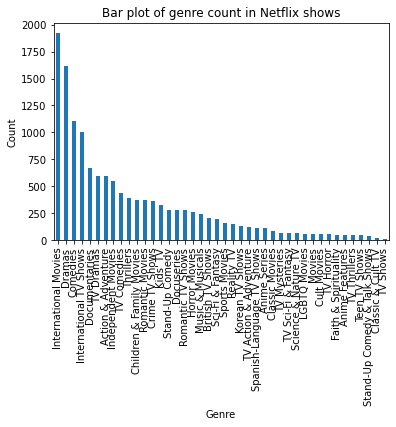

In [10]:
genre_count = genre_list.value_counts()

genre_count.plot.bar()
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Bar plot of genre count in Netflix shows')
genre_count

In the bar plot, we can see the ranking of the shows based on its frequency in Netflix shows. We see that the top 5 genres include 'International Movies', 'Dramas', 'Comedies', 'International TV Shows', and 'Documentaries'. 'International Movies' appear most frequently with 1922 appearances in the dataset.

#### 2.) What is the distribution of International Movies based on their release year in the Netflix catalogue?

As we can see from the bar plot of the genre frequency, 'International Movies' was determined to be the most frequent genre in the dataset. Knowing this, the second exploratory question will focus on the distribution of 'International Movies' according to its release year in the Netflix dataset. 

First we need to create a dataframe which only contain the shows which are listed as 'International Movies' in the dataset. However, we need to know if additional cleaning needs to be performed, since we need the columns `listed_in` and `release_year` to have values.

In [11]:
netflix_df_clean.isnull().any()

show_id         False
type            False
title           False
director         True
cast             True
country          True
date_added       True
release_year    False
rating           True
duration        False
listed_in       False
description     False
dtype: bool

We no longer need to perform additional data cleaning, since the dataset has no null values for `listed_in` or `release_year`.  We can now create the dataset which will contain the shows listed as 'International Movies'

In [12]:
netflix_df_international = netflix_df_clean
netflix_df_international.insert(12, "isInternationalMV", netflix_df_clean["listed_in"].str.find("International Movies") != -1, True)
netflix_df_international = netflix_df_international[netflix_df_international.isInternationalMV]
netflix_df_international

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,isInternationalMV
6,70304989,Movie,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...","Bulgaria, United States, Spain, Canada","September 8, 2017",2014,R,110 min,"International Movies, Sci-Fi & Fantasy, Thrillers","In a dystopian future, an insurance adjuster f...",True
11,70299204,Movie,Kidnapping Mr. Heineken,Daniel Alfredson,"Jim Sturgess, Sam Worthington, Ryan Kwanten, A...","Netherlands, Belgium, United Kingdom, United S...","September 8, 2017",2015,R,95 min,"Action & Adventure, Dramas, International Movies","When beer magnate Alfred ""Freddy"" Heineken is ...",True
21,80046728,Movie,Moonwalkers,Antoine Bardou-Jacquet,"Ron Perlman, Rupert Grint, Robert Sheehan, Ste...","France, Belgium","September 8, 2017",2015,R,96 min,"Action & Adventure, Comedies, International Mo...","A brain-addled war vet, a failing band manager...",True
29,70241607,Movie,Laddaland,Sopon Sukdapisit,"Saharat Sangkapreecha, Pok Piyatida Woramusik,...",Thailand,"September 7, 2018",2011,TV-MA,112 min,"Horror Movies, International Movies",When a family moves into an upscale housing de...,True
32,80159586,Movie,The Most Assassinated Woman in the World,Franck Ribière,"Anna Mouglalis, Niels Schneider, André Wilms, ...","Belgium, United Kingdom, United States","September 7, 2018",2018,TV-MA,102 min,"Dramas, International Movies, Thrillers","In 1930s Paris, an actress famous for her gory...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5568,80158479,Movie,Salaakhen,A. Salaam,"Shashi Kapoor, Sulakshana Pandit, Mehmood, Sud...",India,"April 1, 2017",1975,TV-14,134 min,"Action & Adventure, International Movies, Musi...",Two close childhood friends take drastically d...,True
5571,80100054,Movie,Skins,Eduardo Casanova,"Ana Polvorosa, Candela Peña, Macarena Gómez, C...",Spain,"April 1, 2017",2017,TV-MA,78 min,"Dramas, International Movies","Deformed, disfigured characters must find a wa...",True
5573,80171439,Movie,The Human Factor: The Untold Story of the Bomb...,Rudradeep Bhattacharjee,NaN,India,"April 1, 2017",2013,TV-PG,53 min,"Documentaries, International Movies, Music & M...",A family of Parsi musicians collectively works...,True
5574,80104237,Movie,The Tenth Man,Daniel Burman,"Alan Sabbagh, Julieta Zylberberg, Usher Barilk...",Argentina,"April 1, 2017",2016,TV-MA,81 min,"Dramas, International Movies",After spending much of his adult life in New Y...,True


Now that we have a dataframe which only contains the shows which have been listed as 'International Movies', we can now use a histogram in order to visualize the distribution of shows listed as 'International Movies' in the Netlflix dataset.

2017    297
2016    282
2018    278
2015    197
2019    150
Name: release_year, dtype: int64

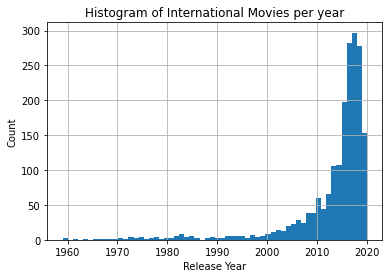

In [13]:
netflix_df_international['release_year'].hist(bins=60)
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.title('Histogram of International Movies per year')

netflix_df_international_count_df = netflix_df_international['release_year'].value_counts()
netflix_df_international_count_df.head()


In [14]:
netflix_df_international.agg({"release_year": ["mean", "std", "count"]})

,release_year
mean,2012.848595
std,8.420091
count,1922.000000


Based on the histogram above, we can describe the shape as negatively-skewed. We can see that within the Netflix catalogue, there is a larger number of shows listed as 'International Movies' which were released towards the latter half of the 2010's, with 2017 having the most number of shows. Also, we were able to determine that the standard deviation of International Movies' release years is 8.42.  

#### 3.) What countries produce the most 'International Movies'?

Considering that our first exploratory question answered that shows listed as 'International Movies' were the most prominent in the Netflix dataset, the third exploratory question would determine which countries these shows most belong to. 

Since we already have a dataframe which contains all the shows listed as 'International Movies', we can use that dataframe for our analysis.

In [15]:
netflix_df_international['country']

6                  Bulgaria, United States, Spain, Canada
11      Netherlands, Belgium, United Kingdom, United S...
21                                        France, Belgium
29                                               Thailand
32                 Belgium, United Kingdom, United States
                              ...                        
5568                                                India
5571                                                Spain
5573                                                India
5574                                            Argentina
5575                                                Spain
Name: country, Length: 1922, dtype: object

As we can see, the `country` column reveals that there are some instances in which a show was produced in more than one country and these countries are separated by commas. As such, we need to parse the `country` column into another table with each row containing all countries of a show, and each column containing only a single country

In [16]:
netflix_df_international_country = netflix_df_international.dropna(subset=['country'])
international_series = netflix_df_international_country['country']
international_matrix = []

for string in international_series:
    split_str = string.split(', ')
    international_matrix.append(split_str)

international_df = pd.DataFrame(international_matrix)
international_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,Bulgaria,United States,Spain,Canada,None,None,None,None,None,None,None,None
1,Netherlands,Belgium,United Kingdom,United States,None,None,None,None,None,None,None,None
2,France,Belgium,None,None,None,None,None,None,None,None,None,None
3,Thailand,None,None,None,None,None,None,None,None,None,None,None
4,Belgium,United Kingdom,United States,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
1849,India,None,None,None,None,None,None,None,None,None,None,None
1850,Spain,None,None,None,None,None,None,None,None,None,None,None
1851,India,None,None,None,None,None,None,None,None,None,None,None
1852,Argentina,None,None,None,None,None,None,None,None,None,None,None


This results in a table with 1,854 observations and 11 columns, which means that the maximum number of countries that the shows in our dataframe were produced in is 11. As such, we can create a series by concatenating each column into one single column. Then we can drop the values which are 'None', thus cleaning the resulting series

In [17]:
country_list = pd.concat([international_df[0], international_df[1], international_df[2], international_df[3], international_df[4], international_df[5], international_df[6], international_df[7], international_df[8], international_df[9], international_df[10], international_df[11]])
country_list.dropna(inplace = True)
country_list

0            Bulgaria
1         Netherlands
2              France
3            Thailand
4             Belgium
            ...      
1674     South Africa
1252      Netherlands
1674           Sweden
1674    United States
1674          Uruguay
Length: 2413, dtype: object

Now that the countries have been separated, we can now use a bar plot to visualize the number of 'International Movies' each country produced in the dataset. 

India              714
France             148
United Kingdom     125
United States      116
Spain              111
                  ... 
Mongolia             1
Lebanon              1
United Kingdom,      1
Vatican City         1
Albania              1
Length: 89, dtype: int64

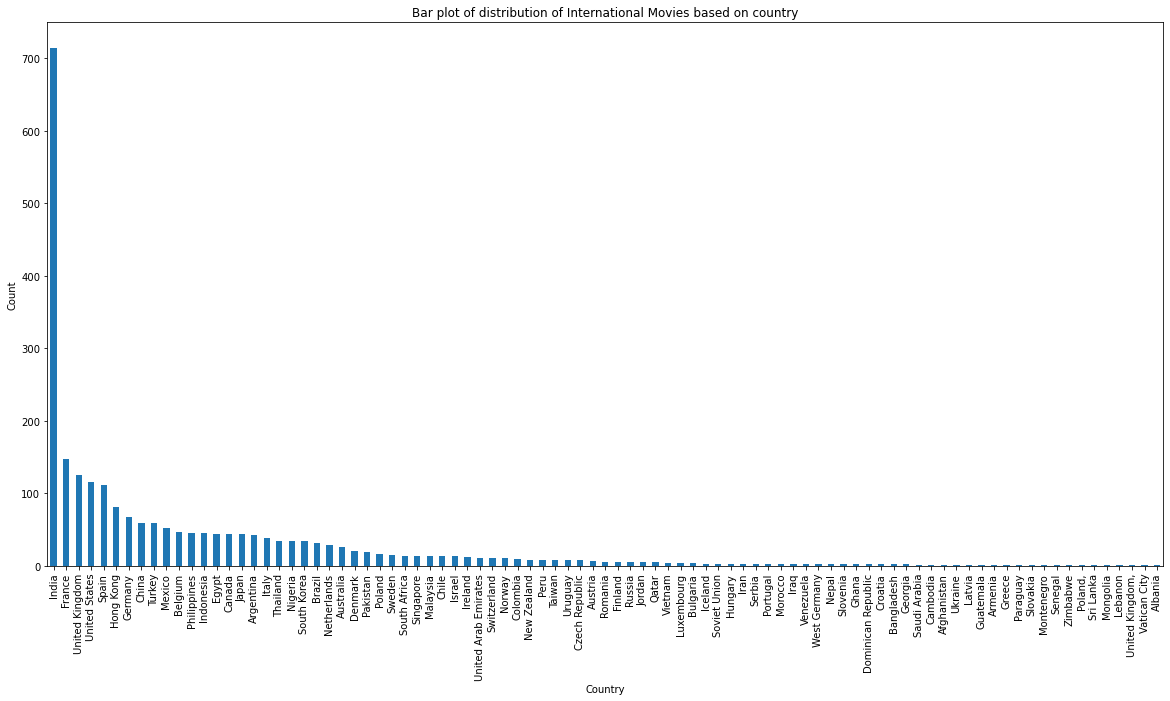

In [18]:
country_count = country_list.value_counts()

country_count.plot.bar(figsize = (20,10))
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Bar plot of distribution of International Movies based on country')
country_count

Based on the bar plot, we see that India produced the most 'International Movies', leading by a large amount. The four other countries with the most produced movies were France, United Kingdom, Unites States, and Spain with roughly similar amounts of shows.

## What are the most common association rules among Netflix genres?
The shows in the netflix dataset contains a `listed_in` column which refers to what genres the shows are listed in, on the streaming platform. Usually, a show is often listed in more than one genre, and there are some genre combinations that are frequently used for shows. [A chord diagram by Dr. Shahin Rostami (2020)](https://datacrayon.com/posts/statistics/data-is-beautiful/co-occurrence-of-movie-genres-with-chord-diagrams/#Conclusion) shows that some of the **most common genre combinations** of movies are as follows:
 - Romance and Comedy
 - Romance and Drama
 - Drama and Thriller
 - Drama and Action
 - Drama and Comedy
 - Crime and Thriller
 - Crime and Drama
 - Action and Adventure
 - Action and Thriller
 
There are some genres that are present in the  netflix shows dataset but are not included in the chord diagram. Furthermore, some genres like 'International Movies' have a high frequency count in the dataset, which could increase the frequency of its genre combinations. We can find out if the previously mentioned genre combinations also apply on the Netflix dataset or if there are more rules associated with the most frequent genres by using **association rules**. The data preparation needed for the following steps is to drop all duplicate shows. There are some observations in the dataset that are the same show but are in different languages. These observations were already dropped in the previously done data cleaning, and the clean dataset will be used to generate the association rules.

### Data Modelling
The values in the `listed_in` column are represented as strings where each string can contain more than one genre, and each genre is separated by commas. To parse these genres we need to create a matrix that is a list of genre lists, where each row represents the genres of one show. We can then use this matrix to create a dataframe that we can manipulate.

In [19]:
listed_in_series = netflix_df_clean['listed_in']
genre_matrix = []

for string in listed_in_series:
    split_str = string.split(', ')
    genre_matrix.append(split_str)

genre_df = pd.DataFrame(genre_matrix)
genre_df

,0,1,2
0,Children & Family Movies,Comedies,None
1,Stand-Up Comedy,None,None
2,Kids' TV,None,None
3,Kids' TV,None,None
4,Comedies,None,None
...,...,...,...
6221,TV Action & Adventure,TV Comedies,TV Sci-Fi & Fantasy
6222,TV Comedies,None,None
6223,Movies,None,None
6224,British TV Shows,TV Comedies,TV Dramas


We also need a value dictionary to assign a number to each genre.

In [20]:
values = genre_df.values.ravel()
values = [value for value in pd.unique(values) if not pd.isnull(value)]

value_dict = {}
for i, value in enumerate(values):
    value_dict[value] = i
value_dict

{'Children & Family Movies': 0,
 'Comedies': 1,
 'Stand-Up Comedy': 2,
 "Kids' TV": 3,
 'Crime TV Shows': 4,
 'International TV Shows': 5,
 'Spanish-Language TV Shows': 6,
 'International Movies': 7,
 'Sci-Fi & Fantasy': 8,
 'Thrillers': 9,
 'Docuseries': 10,
 'Science & Nature TV': 11,
 'Action & Adventure': 12,
 'Dramas': 13,
 'Cult Movies': 14,
 'Independent Movies': 15,
 'Romantic Movies': 16,
 'Documentaries': 17,
 'Horror Movies': 18,
 'Romantic TV Shows': 19,
 'TV Comedies': 20,
 'TV Dramas': 21,
 'TV Thrillers': 22,
 'TV Mysteries': 23,
 'British TV Shows': 24,
 'Music & Musicals': 25,
 'Reality TV': 26,
 'TV Action & Adventure': 27,
 'Anime Features': 28,
 'Teen TV Shows': 29,
 'Faith & Spirituality': 30,
 'Korean TV Shows': 31,
 'Anime Series': 32,
 'LGBTQ Movies': 33,
 'TV Horror': 34,
 'Movies': 35,
 'Stand-Up Comedy & Talk Shows': 36,
 'TV Sci-Fi & Fantasy': 37,
 'Classic Movies': 38,
 'Sports Movies': 39,
 'TV Shows': 40,
 'Classic & Cult TV': 41}

After generating the dictionary, we can then create a dataframe where each row is a netflix show and each column is a genre. If the show is listed in that genre then the value for that column is `1` and `0` if it is not

In [21]:
genre_df = genre_df.stack().map(value_dict).unstack()

baskets = []
for i in range(genre_df.shape[0]):
    basket = np.sort([int(x) for x in genre_df.iloc[i].values.tolist() if str(x) != 'nan'])
    baskets.append(basket)

shows_df = pd.DataFrame([[0 for _ in range(len(value_dict))] for _ in range(len(baskets))], columns=values)

for i, basket in enumerate(baskets):
    shows_df.iloc[i, basket] = 1
shows_df

,Children & Family Movies,Comedies,Stand-Up Comedy,Kids' TV,Crime TV Shows,International TV Shows,Spanish-Language TV Shows,International Movies,Sci-Fi & Fantasy,Thrillers,...,Anime Series,LGBTQ Movies,TV Horror,Movies,Stand-Up Comedy & Talk Shows,TV Sci-Fi & Fantasy,Classic Movies,Sports Movies,TV Shows,Classic & Cult TV
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
6224,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Rule Miner

After preparing the dataframe, we can finally use a **Rule Miner** to figure out the common genre association rules of netflix shows. There can be many configurations of this Rule Miner that will produce different results. Because of this, multiple tests will be done on the dataset which will fulfill different purposes.

The first configuration will be setting the support threshold to the **lowest occurence** of a genre. This will be done to accomodate all genres in the dataset since all genres have appeared that many times. To do this we must first get all the total counts of each genre, then get the lowest value from the results. Since the total count of each genre has already been generated in the Exploratory Data Analysis, all we need to do is get the minimum value from that series.

In [22]:
print("Last 10 results of the series\n")
print(genre_count.tail(10),"\n")
print("Minimum no. of occurrences:", genre_count.min())

Last 10 results of the series

Movies                          56
Cult Movies                     55
TV Horror                       54
Faith & Spirituality            47
Anime Features                  45
TV Thrillers                    44
Teen TV Shows                   44
Stand-Up Comedy & Talk Shows    42
Classic & Cult TV               24
TV Shows                        10
dtype: int64 

Minimum no. of occurrences: 10


The minimum value of the total genre counts is `10`, which will be set as the support threshold.

The confidence level is then lowered starting from `100%` until it produces at least 1 association rule

From this result, we initialize the first Rule Miner to have a **support threshold** of `10` and a **confidence** of `100%`.

In [23]:
rule_miner_lowest_occur = RuleMiner(10, 1)
assoc_rules_lowest_occur = rule_miner_lowest_occur.get_association_rules(shows_df)
assoc_rules_lowest_occur

[[['Crime TV Shows', 'Korean TV Shows'], ['International TV Shows']],
 [['International TV Shows', 'Science & Nature TV'], ['Docuseries']],
 [['Science & Nature TV', 'International TV Shows'], ['Docuseries']],
 [['Korean TV Shows', 'Romantic TV Shows'], ['International TV Shows']],
 [['Korean TV Shows', 'TV Dramas'], ['International TV Shows']],
 [['British TV Shows', 'Science & Nature TV'], ['Docuseries']],
 [['British TV Shows', 'Science & Nature TV'], ['Docuseries']]]

From the result of the get_association_rules function of the rule miner, we can see that the genre association rules are:
 - ['Crime TV Shows', 'Korean TV Shows'] → ['International TV Shows']
 - ['International TV Shows', 'Science & Nature TV'] → ['Docuseries']
 - ['Science & Nature TV', 'International TV Shows'] → ['Docuseries']
 - ['Romantic TV Shows', 'Korean TV Shows'] → ['International TV Shows']
 - ['TV Dramas', 'Korean TV Shows'] → ['International TV Shows']
 - ['British TV Shows', 'Science & Nature TV'] → ['Docuseries']

The second configuration will be setting the support threshold to the **average occurence** of all genres. This will be done to make sure that the genres that will be included in the rules must have occured a sufficient number of times. We can reuse the total counts of each genre and get the mean value from the series.

In [24]:
print("Average no. of occurrences:", genre_count.mean())

Average no. of occurrences: 324.92857142857144


The minimum value of the total genre counts is `324.93`, which we can round off and set as the support threshold.

The confidence level is then lowered starting from `100%` until it produces at least 1 association rule

From this result, we initialize this Rule Miner to have a **support threshold** of `325` and a **confidence** of `74%`.

In [25]:
rule_miner_mean_occur = RuleMiner(325, 0.74)
assoc_rules_mean_occur = rule_miner_mean_occur.get_association_rules(shows_df)
assoc_rules_mean_occur

[[['Independent Movies'], ['Dramas']]]

From the result of the get_association_rules function of the rule miner, we can see that the only genre association rule produced is:
 - ['Independent Movies'] → ['Dramas']

The last configuration will be setting the support threshold to **1% of the total shows** on Netflix. This will be done to generate as many association rules as possible. We can simply multiply 0.01 to the number of rows in our dataframe to get our support threshold.

In [26]:
print("1% of total number of shows:", len(shows_df.index)*0.01)

1% of total number of shows: 62.26


1% of the total number of all shows is `62.26`, which we can round off and set as the support threshold.

Additionally, we set the confidence level to `40%` to generate more rules than the previous tests.

From this result, we initialize this Rule Miner to have a support threshold of `62` and a confidence of `40%`.

In [27]:
rule_miner_1percent = RuleMiner(62, 0.4)
assoc_rules_1percent = rule_miner_1percent.get_association_rules(shows_df)
assoc_rules_1percent

[[['Dramas', 'Comedies'], ['International Movies']],
 [['Romantic Movies', 'Comedies'], ['International Movies']],
 [['Romantic Movies', 'International Movies'], ['Comedies']],
 [['Comedies', 'Independent Movies'], ['Dramas']],
 [['Crime TV Shows', 'International TV Shows'], ['TV Dramas']],
 [['Crime TV Shows', 'TV Dramas'], ['International TV Shows']],
 [['TV Comedies', 'Romantic TV Shows'], ['International TV Shows']],
 [['Romantic TV Shows', 'TV Dramas'], ['International TV Shows']],
 [['Dramas', 'Thrillers'], ['International Movies']],
 [['Thrillers', 'International Movies'], ['Dramas']],
 [['Dramas', 'Action & Adventure'], ['International Movies']],
 [['Dramas', 'Independent Movies'], ['International Movies']],
 [['International Movies', 'Independent Movies'], ['Dramas']],
 [['Romantic Movies', 'Dramas'], ['International Movies']],
 [['Romantic Movies', 'International Movies'], ['Dramas']],
 [['Dramas', 'Thrillers'], ['International Movies']],
 [['International Movies', 'Thrillers

From the result of the get_association_rules function of the rule miner, we can see that genre association rules produced are:
 - ['Comedies', 'Dramas'] → ['International Movies']
 - ['Comedies', 'Romantic Movies'] → ['International Movies']
 - ['International Movies', 'Romantic Movies'] → ['Comedies']
 - ['Comedies', 'Independent Movies'] → ['Dramas']
 - ['Crime TV Shows', 'TV Dramas'] → ['International TV Shows']
 - ['Crime TV Shows', 'International TV Shows'] → ['TV Dramas']
 - ['TV Comedies', 'Romantic TV Shows'] → ['International TV Shows']
 - [['TV Dramas', 'Romantic TV Shows'] → ['International TV Shows']
 - ['International Movies', 'Thrillers'] → ['Dramas']
 - ['Dramas', 'Thrillers'] → ['International Movies']
 - ['Action & Adventure', 'Dramas'] → ['International Movies']
 - ['International Movies', 'Independent Movies'] → ['Dramas']
 - ['Independent Movies', 'Dramas'] → ['International Movies']
 - ['International Movies', 'Romantic Movies'] → ['Dramas']
 - ['Dramas', 'Romantic Movies'] → ['International Movies']
 - ['Thrillers', 'International Movies'] → ['Dramas']
 - ['Thrillers', 'Dramas'] → ['International Movies']

### Insights and Conclusions

One limitation that was met in this research question is that there are only a maximum of 3 genres per show that is recorded in the `listed_in` column of the dataset. On the streaming platform itself, you cann actually find that there can be more than 3 genre listings per show, and this did not reflect in the dataset.

The **first** rule miner with a support threshold of `10` and a confidence of `100%` produced the following association rules:
 - ['Crime TV Shows', 'Korean TV Shows'] → ['International TV Shows']
 - ['International TV Shows', 'Science & Nature TV'] → ['Docuseries']
 - ['Science & Nature TV', 'International TV Shows'] → ['Docuseries']
 - ['Romantic TV Shows', 'Korean TV Shows'] → ['International TV Shows']
 - ['TV Dramas', 'Korean TV Shows'] → ['International TV Shows']
 - ['British TV Shows', 'Science & Nature TV'] → ['Docuseries']

What was interesting about this result is that even though the confidence level has not been lowered yet there were a lot of association rules generated. For the dataset, this means that whenever the itemsets on the left side of the rules are present in the `listed_in` column, the third item will always be what is on the right side of the rules generated. For Netflix, it means that there is only a very high chance of the shows following the rules generated, since not all netflix shows might be included in the dataset and there is a limit of 3 genres per show. For all shows, including those not in Netflix, there could be a lower probability of these rules being followed, since Netflix only adds shows to their streaming platform which caters to the preferences of their target market.

All of the genres from these results were not included in the genre chord chart. However, it is noteable how 5 out of 6 of the generated rules contained the 'International TV Shows' genre. This genre is the 4th most frequent genre with 1001 occurrences. It may be because of the frequency that the genre appeared in these rules but it does not explain why the other top 3 most frequent genres are not included in the results. It could be due to the confidence level being very high and the rules associated with the other 3 most frequent genres do not occur 100% of the time.

The **second** rule miner with a support threshold of `325` and a confidence of `74%` produced the following association rule:
 - ['Independent Movies'] → ['Dramas']
 
This result is interesting as there are only two genres in the rules. The rule states that whenever a show is listed as an 'Independent Movie' it has a 74% chance of also being listed in 'Dramas'. It could be derived that a lot of Independent or 'Indie' movies are dramas. During this time, Indie Movies are popular for winning awards or for simply being good. There could be a trend of indie drama movies that support the rule generated but that is a different question with a different solution to arrive at the answer.

Another interesting observation is that none of the genres from the first set of association rules made it to the current results. This could mean that their itemsets had low support which removed them from the set of frequent itemsets used to generate the rules.

The **third** rule miner with a support threshold of `62` and a confidence of `40%` produced the following association rules:
 - ['Comedies', 'Dramas'] → ['International Movies']
 - ['Comedies', 'Romantic Movies'] → ['International Movies']
 - ['International Movies', 'Romantic Movies'] → ['Comedies']
 - ['Comedies', 'Independent Movies'] → ['Dramas']
 - ['Crime TV Shows', 'TV Dramas'] → ['International TV Shows']
 - ['Crime TV Shows', 'International TV Shows'] → ['TV Dramas']
 - ['TV Comedies', 'Romantic TV Shows'] → ['International TV Shows']
 - [['TV Dramas', 'Romantic TV Shows'] → ['International TV Shows']
 - ['International Movies', 'Thrillers'] → ['Dramas']
 - ['Dramas', 'Thrillers'] → ['International Movies']
 - ['Action & Adventure', 'Dramas'] → ['International Movies']
 - ['International Movies', 'Independent Movies'] → ['Dramas']
 - ['Independent Movies', 'Dramas'] → ['International Movies']
 - ['International Movies', 'Romantic Movies'] → ['Dramas']
 - ['Dramas', 'Romantic Movies'] → ['International Movies']
 - ['Thrillers', 'International Movies'] → ['Dramas']
 - ['Thrillers', 'Dramas'] → ['International Movies']
 
The rules generated by this third rule miner are reflective of the common genre combinations that can be found from [Dr. Shahin Rostami's chord diagram.](https://datacrayon.com/posts/statistics/data-is-beautiful/co-occurrence-of-movie-genres-with-chord-diagrams/#Conclusion) Each combination from the combinations 'Romance and Comedy', 'Romance and Drama', 'Drama and Thriller', 'Drama and Action', 'Drama and Comedy', and 'Crime and Drama', all appear in at least one rule from the generated results. The only combinations not present are 'Action and Thriller', Crime and Thriller, and Action and Adventure, which is a single genre on its own. The only genres in the results that are not in the chord chart are 'International Movies', 'International TV Shows', and 'Independent Movies'. In addition, the top 4 most frequent genres are included in this dataset, including other frequently listed genres.

To answer the question, "What are the most common association rules among Netflix genres?", it would be the association rules generated by the **third rule miner** with a support of `62` and a confidence of `40%`. This is because the first rule miner did not have frequent enough itemsets, that the results it generated can no longer be found in the other rule miners. It is also notable that a confidence of 100% is too strict for association rules that do not occur one hundred percent of the time. The second rule miner also has a high support threshold, which eliminates some frequent enough itemsets. Additionally, the confidence level was too high especially for a rule miner with a high support threshold. The second rule miner limited and eliminated too many rules that could have been meaningful. The third rule miner had a sufficiently low support threshold of `62`, which accomodated a lot of itemsets. The confidence level of `40%` also increased the number of association rules generated, and it is not too low since the itemsets are already frequent enough and there are not too many rules generated.

If further improvements could be made, it would be finding a specific value for the support threshold to say that a set of genre combinations occurs frequently enough. Additionally, it would be better to find and use a dataset that would not limit the number of genres a show could be listed in. This could create more meaningful rules which could help in answering other questions like genre trends or help in creating netflix user profiles for recommender systems.

## Are Netflix synopses informative enough to classify whether shows belong to the International Movies genre?

The `description` variable in the dataset refers to Netflix's synopsis of each show. For this research question, the idea is to determine whether these synopses are informative enough to classify whether a show is classified under *International Movies*. This entails building a classifier which would be able to identify all *International Movie* shows in the dataset.

This is interesting because the problem leads to more questions about how informative Netflix synopses are. Are plots &mdash; represented by the synopses &mdash; dependent of genre? Are stories similar for the same genre? Are words able to represent genres? These will not be answered in this research problem, but are indications of the many stimulating possibilities that this research problem entails. It's also an indication of the capabilities of computers in handling natural language.

The *International Movies* genre is chosen because 1,922 shows are classified under this genre which makes it the most prominent. Choosing a prominent genre is important because there is a need to have a good amount of samples; this is especially true for classification which requires good representatives for each categories &mdash; in this case, the categories are "International Movies" and "Not International Movies". For this problem, only the `description` and `listed_in` variables from the Netflix dataset will be used. 

### Data Preparation

For this classification, two sets of data are needed: data which contains only shows with *International Movies* as its genre (regardless whether it's also classified as other genres), and data containing shows which are not classified under *International Movies*.

In the exploratory data analysis, there's already a `DataFrame` pertaining to the first. What we need is a `DataFrame` for shows that aren't classified under *International Movies*. To do this, the `isInternationalMV` variable from `netflix_df_clean`, can be used where False values indicates that show is not under said classification. After getting the False values, the next step is to concatenate both "Not International Movies" and "International Movies" data together to prepare it for feature extraction.

In [28]:
netflix_df_non_international = netflix_df_clean[netflix_df_clean["isInternationalMV"] == False]
netflix_df_non_international

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,isInternationalMV
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,False
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,False
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob...",False
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,False
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6229,80000063,TV Show,Red vs. Blue,NaN,"Burnie Burns, Jason Saldaña, Gustavo Sorola, G...",United States,NaN,2015,NR,13 Seasons,"TV Action & Adventure, TV Comedies, TV Sci-Fi ...","This parody of first-person shooter games, mil...",False
6230,70286564,TV Show,Maron,NaN,"Marc Maron, Judd Hirsch, Josh Brener, Nora Zeh...",United States,NaN,2016,TV-MA,4 Seasons,TV Comedies,"Marc Maron stars as Marc Maron, who interviews...",False
6231,80116008,Movie,Little Baby Bum: Nursery Rhyme Friends,NaN,NaN,NaN,NaN,2016,NaN,60 min,Movies,Nursery rhymes and original music for children...,False
6232,70281022,TV Show,A Young Doctor's Notebook and Other Stories,NaN,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,NaN,2013,TV-MA,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ...",False


In [29]:
netflix_df_classifier = pd.concat([netflix_df_non_international, netflix_df_international])
netflix_df_classifier

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,isInternationalMV
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,False
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,False
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob...",False
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,False
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5568,80158479,Movie,Salaakhen,A. Salaam,"Shashi Kapoor, Sulakshana Pandit, Mehmood, Sud...",India,"April 1, 2017",1975,TV-14,134 min,"Action & Adventure, International Movies, Musi...",Two close childhood friends take drastically d...,True
5571,80100054,Movie,Skins,Eduardo Casanova,"Ana Polvorosa, Candela Peña, Macarena Gómez, C...",Spain,"April 1, 2017",2017,TV-MA,78 min,"Dramas, International Movies","Deformed, disfigured characters must find a wa...",True
5573,80171439,Movie,The Human Factor: The Untold Story of the Bomb...,Rudradeep Bhattacharjee,NaN,India,"April 1, 2017",2013,TV-PG,53 min,"Documentaries, International Movies, Music & M...",A family of Parsi musicians collectively works...,True
5574,80104237,Movie,The Tenth Man,Daniel Burman,"Alan Sabbagh, Julieta Zylberberg, Usher Barilk...",Argentina,"April 1, 2017",2016,TV-MA,81 min,"Dramas, International Movies",After spending much of his adult life in New Y...,True


In [30]:
print("International Movies:", len(netflix_df_international))
print("Not International Movies:", len(netflix_df_non_international))

International Movies: 1922
Not International Movies: 4304


- **Total International Movies shows:** 1,922 shows

- **Total Not International Movies shows:** 4,304 shows

### Feature Extraction
The `description` variable is in the form of sentences (naturally, because synopses are written with words). The task is to evaluate the value of words in these synposes.  However, computers do not really understand sentences. Hence, a mathematical model is important to transform the words into a numerical representation. 

#### TF-IDF
The term frequency-inverse document frequency (TF-IDF) is a statistical method which places value in words through an inverse proportion of the word's frequency in a document, in this case the `description`, to the amount of documents the word appears in. The importance of a word is indicated by a high TF-IDF value. The TF-IDF value is given by the formula: 

$$W_{i,j} = tf_{i,j} \times log{N \over df_{i}}$$

Where:

$tf_{i,j}$ = number of occurences of $i$ in $j$,

$df_{i}$ = number of documents containing $i$, and

$N$ = total number of documents

Scikit-learn's [TF-IDF Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) was utilized to transform the `description` column into a matrix of TF-IDF features. First we fit the documents (i.e. the synposes) by using the vectorizer's `fit` function for the vectorizer to learn the vocabulary. Once vectorizer knows the vocabulary and document frequencies, the `transform` function is used to transform the documents into a document-term matrix.  

In [31]:
vectorizer=TfidfVectorizer()
vectorizer.fit(netflix_df_classifier["description"])
features=vectorizer.transform(netflix_df_classifier["description"])
features

<6226x16411 sparse matrix of type '<class 'numpy.float64'>'
	with 133898 stored elements in Compressed Sparse Row format>

We see that the TF-IDF Vectorizer converted the `description` column into a sparse matrix of TF-IDF values where each row contains 16,411 columns. This also means that there are 16411 words that were extracted as features from the dataset. To confirm this, we can get the word form of the features from the vectorizer by using its `get_feature_names` function.

In [32]:
features_words = vectorizer.get_feature_names()
print(features_words)

['000', '007', '009', '10', '100', '1000', '102', '10th', '11', '112', '11th', '12', '13', '130', '13th', '14', '14th', '15', '150', '15k', '15th', '16', '1666', '16th', '17', '1778', '17th', '18', '1800s', '1806', '1812', '1821', '1827', '1843', '1854', '1860s', '1866', '1867', '1870', '1871', '1880s', '1881', '1888', '1890', '1890s', '1892', '1897', '1899', '18th', '19', '1900s', '1901', '1902', '1905', '1913', '1915', '1919', '1920s', '1921', '1929', '1930s', '1931', '1934', '1936', '1937', '1940', '1940s', '1942', '1943', '1945', '1946', '1947', '1948', '1949', '1950', '1950s', '1951', '1953', '1959', '1960', '1960s', '1961', '1962', '1963', '1966', '1967', '1968', '1969', '1970', '1970s', '1971', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1980s', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1990s', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '19th', '20', '200', '2000', '2001', '2002', '2003', '2

In [33]:
len(features_words)

16411

The above is a list of all the words, sorted alphabetically, that the vectorizer learned and, consequently, used as features to build the sparse matrix. Results show that there are indeed 16411 features for each row (and thus, for each show).

### Preparing labels
In order for the classifier to classify, it should be trained knowing the labels &mdash; in this case *International Movie* or *Not International Movie* &mdash; of the show it's trying to classify. The next step is to prepare these labels by utilizing the `isInternationalMV` variable of the dataset to form an array of labels. *International Movie* shows are represented as 1s, while *Not International Movie* shows are represented as 0s.

In [34]:
labels=[]
for show in netflix_df_classifier["isInternationalMV"]:
    if show == True:
        appenddata=1
    if show == False:
        appenddata=0
    labels.append(appenddata)
    
labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


Because *Not International Movie* shows and *International Movie* shows were simply concatenated, it's expected that the dataset is split homogenously where the first parts are all *Not International Movie* shows and the latter are *International Movie* shows. This is not a problem, however, since a stratified cross-validation approach will be utilized which splits the data such that there will be close-as-possible distribution of classes.

### Building a classifier and measuring performance
This [chart](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) from scikit-learn was utilized to choose the right estimator for this problem. The circumstances of this research lead us to selecting [`LinearSVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) from scikit-learn's support vector machine module.

Feeding the data to the machine algorithm can be manually done by using the functions of the `LinearSVC` class. However, as mentioned earlier, cross-validation will be used in evaluating the performance of the dataset. For this purpose,  [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate) will allow us to both build the classifier, and evaluate its performance at the same time. For binary classification problems such as what we have, `cross_validate` automatically uses the [`StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) as its cross-validation splitter, hence, we minimize having bias in each fold.

The first step is to initialize the estimator (Linear SVC), and name the metrics/scoring that will be used by the cross-validation in evaluating performance. Default parameters were used for the estimator.

In [35]:
linearSVC=svm.LinearSVC()
scoring = ['accuracy', 'recall', 'precision']

Then, we simply use the estimator, the features, the labels, and the scorers as parameters for `cross_validate`.

In [36]:
scores = cross_validate(linearSVC, features, labels, scoring=scoring)
print('Mean Accuracy:', scores['test_accuracy'].mean())
print('Accuracy Two Standard Deviations:', scores['test_accuracy'].std() * 2)
print('Mean Precision', scores['test_precision'].mean())
print('Mean Recall', scores['test_recall'].mean())

Mean Accuracy: 0.7222934756683235
Accuracy Two Standard Deviations: 0.029788732401879806
Mean Precision 0.5782889934018047
Mean Recall 0.398030303030303


- **95% Confidence Interval of Genre Classifier Accuracy:** 72.23% $\pm$ 2.98

- **Average Genre Classifier Precision:** 57.83%

- **Average Genre Classifier Recall:** 39.80%

To get more information, we can extract the top features by using [`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html?highlight=selectkbest#sklearn.feature_selection.SelectKBest) which returns the top *k* features based on a scoring function. In this case, we will use [`Chi-squared statistics`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2)because it is expected that the features &mdash; in the form of TF-IDF values &mdash; will never be negative. Furthermore, because chi-squared statistics measures dependence between variables, it can be used to determine which features are independent of classes, hence, not useful in classification. 

### Top features for classification

In [37]:
selector = SelectKBest(chi2, k=20)
selector.fit(features, labels)
# Get idxs of columns to keep
top_features_idxs = selector.get_support(indices=True)

scores, pval=(chi2(features, labels))

chi2_data={'Feature Names': np.array(features_words)[top_features_idxs], 'Chi2': scores[top_features_idxs], 'P-value': pval[top_features_idxs]}
features_chi2 = pd.DataFrame(chi2_data).sort_values(by=['Chi2'], ascending=False, ignore_index=True)
features_chi2

,Feature Names,Chi2,P-value
0,man,16.566342,0.000047
1,india,12.949131,0.000320
2,mumbai,12.911859,0.000327
3,marry,12.165443,0.000487
4,series,10.884034,0.000970
5,woman,9.681524,0.001861
6,young,7.454050,0.006329
7,his,7.257822,0.007059
8,bollywood,7.118171,0.007631
9,comedian,6.391168,0.011469


The `DataFrame` shows the top 20 most class-dependent features identified through chi-squared statistics. When the classifier sees these words in the synopses, there is a high probability that it would be able to classify whether the show is an *International Movie* or not correctly.

Note, however, that the results are based on the evaluation of the data as a whole (i.e. did not follow the cross-validation scheme), and without consideration of the machine learning algorithm. The implication is that it may not be representative of the the performance of the classifiers that were measured during cross-validation. Nevertheless, this method still shows a general idea of what the top features would be for a classifier that is built with synopses and genre data from the Netflix dataset. 

### Insights and Conclusion

#### Accuracy
The 95% confidence interval for a Netflix genre classifier's accuracy is 72.23% $\pm$ 2.98. This means that the classifier, more than half of the time, was able to classify whether a show is an *International Movie* or *Not International Movie*. Only considering accuracy, this can be interpreted as successful.

However, even though a stratified cross-validation was used, there is still some class imbalance because the dataset contains 1,922 *International Movie* shows, and 4,304 *Not International Movie* shows. The latter class is more than twice the other. This renders the accuracy measure an inferior evaluator because it can yield a high accuracy even if it fails to classify a lot of International Movie shows.

For instance, if the classifier were to correctly guess all *Not International Movie* shows:

In [38]:
intl_total = 1922
non_intl_total = 4304
    
non_intl_total / (intl_total + non_intl_total)

0.6912945711532283

The accuracy would be 69.13% which can still be interpreted as the classifier being able to correctly classify more than half the time. Given so, we can look at [precision and recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall). The former is concerned with the correct *International Movie* show predictions, while the latter is concerned with the number of actual *International Movie* shows that were identified by the classifier.

#### Precision and Recall
The average precision for the classifiers is 57.83%. This means that more than half the time, when the classifiers predict a show to be under *International Movies*, it is true. Meanwhile, the average recall for the classifiers is 39.80%. This means that the classifiers were only able to identify less than half of all the *International Movie* shows. Given a standard of 50%, the classifiers were not successful at all.

Given that the goal was to correctly identify all *International Movies* shows from the data, we focus on recall. By doing so, we can say that although accuracy is high, the classifiers are not able to satisfactorily identify the *International Movie* shows.

However, this means that accuracy is truly affected by the class imbalance. The implication is that the classifier were probably able to classify *Not International Movie* shows, at least better than its counterpart. To test this we can flip the labels to say that the true positives are the *Not International Movie* shows.

In [39]:
invert_labels=[]
for show in netflix_df_classifier["isInternationalMV"]:
    if show == True:
        appenddata=0
    if show == False:
        appenddata=1
    invert_labels.append(appenddata)
    
invert_labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [40]:
invert_scores = cross_validate(linearSVC, features, invert_labels, scoring=scoring)
print('Mean Precision', invert_scores['test_precision'].mean())
print('Mean Recall', invert_scores['test_recall'].mean())

Mean Precision 0.7634492872799595
Mean Recall 0.867113686087027


- **Average Precision:** 76.34%

- **Average Recall:** 86.71%

The results show an astounding increase in performance. Recall increased more than twice which indicates that the classifiers were able to predict most of the *Not International Movie* shows in the dataset. 

Thus, it can still be said that synopses are still informative in genre classification, just the other way around. In future studies, a better way to test this is to have a dataset that have equal, or close distribution of classes.

#### Top Features
The top class-dependent features also gives insight about the performance of the classifier.

In [41]:
features_chi2

,Feature Names,Chi2,P-value
0,man,16.566342,0.000047
1,india,12.949131,0.000320
2,mumbai,12.911859,0.000327
3,marry,12.165443,0.000487
4,series,10.884034,0.000970
5,woman,9.681524,0.001861
6,young,7.454050,0.006329
7,his,7.257822,0.007059
8,bollywood,7.118171,0.007631
9,comedian,6.391168,0.011469


Looking at the table, there words that can be identified to match with the idea of an international movie:
- Bollywood
- India
- Indian
- Mumbai
- Caste

Under a 0.05 significance level, these are all hugely relevant to the classification process. It's also worth noting that these words are all related to India. This result is consistent with the findings in the exploratory data analysis stating that most of the shows that fall under the *International Movies* genre &mdash; 714 shows to be exact &mdash; is produced in India.

In [42]:
country_count

India              714
France             148
United Kingdom     125
United States      116
Spain              111
                  ... 
Mongolia             1
Lebanon              1
United Kingdom,      1
Vatican City         1
Albania              1
Length: 89, dtype: int64

Thus, it is expected that the chi-squared statistics, given a set of *International Movies* shows, most of which are produced in India, would find Indian-related words to be relevant features for classification. 

#### Conclusion

Therefore, based on analysis, it can be said that Netflix synopses are not informative enough in classifying if shows belong to the International Movies genre. However, if the goal was identifying the opposite, Netflix synopses prove to be informative. In this latter context, performance metrics reveal that the classifier was able to perform well given only show synopses and their corresponding genre. 

Meanwhile, a brief top-features analysis show that synopses contain information, specifically words, that are relevant to its genre, and consequently, the classification. 

In the future, it is recommended to conduct parameter tuning for the estimator to see whether there are better parameters that would yield better classifier performance; a better performance may conclude that the problem was not due to the dataset, but with the classifier's setup. Another recommendation is to consider other metrics such as the confusion matrix to further analyze results and why the classifier behaves the way it does. It is also recommended that further data preprocessing techniques be done such as lemmatization, and stop words removal. Finally, in line with the chi-squared statistics of finding the top features, further analysis can be done to find out which words can describe *International Movies* in Netflix. 